# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Features](#Features)
- [Clustering](#Clustering)
    - [4-Seam](#4-Seam-Fastball)
    - [Cutter](#Cutter)
    - [Sinker](#Sinker)
    - [Slider](#Slider)
    - [Curveball](#Curveball)
    - [Changeup](#Changeup)
- [Linear Regression Modeling](#Linear-Regression-Modeling)
    - [4-Seam](#Linear-Regression---4-Seam)
    - [Cutter](#Linear-Regression---Cutter)
    - [Sinker](#Linear-Regression---Sinker)
    - [Slider](#Linear-Regression---Slider)
    - [Curveball](#Linear-Regression---Curveball)
    - [Changeup](#Linear-Regression---Changeup)

# Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, k_means
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches.csv')
data.drop(columns = ['Unnamed: 0'], inplace = True) 
data.dropna(inplace = True)

pd.set_option('max_columns', None)
print(data.shape)
data.head(5)

(116889, 30)


,player_name,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_-x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_-x,plate_x,plate_z,swing_miss,delta_run_exp,stand,hit_distance_sc,exit_velo,launch_angle,launch_speed_angle,xba,xwobacon,woba_value,woba_denom,babip_value,iso_value
0,"Smith, Will",L,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,1.40,6.80,6.5,54.03,0.69,-0.69,2.83,0,-0.073,R,13.0,95.2,-13.0,2.0,0.174,0.158,0.0,1.0,0.0,0.0
4,"Smith, Will",L,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,1.49,6.66,6.3,54.15,0.31,-0.31,2.80,0,-0.189,L,9.0,93.3,-18.0,2.0,0.100,0.090,0.0,1.0,0.0,0.0
9,"Gsellman, Robert",R,SI,94.3,1982.0,221.0,16.20,10.56,21.018028,94.4,-1.20,6.05,6.5,53.98,0.26,-0.26,1.78,0,-0.061,R,140.0,75.3,65.0,3.0,0.000,0.000,0.0,1.0,0.0,0.0
18,"Gsellman, Robert",R,SL,90.5,2133.0,216.0,-0.12,7.44,23.569061,91.1,-1.51,5.93,6.3,54.23,-0.01,0.01,2.23,0,-0.173,L,294.0,96.8,18.0,4.0,0.409,0.457,0.0,1.0,0.0,0.0
27,"Martin, Chris",R,FF,94.9,2224.0,216.0,9.00,14.16,23.435195,95.5,-2.71,6.38,6.6,53.86,0.10,-0.10,1.94,0,-0.163,R,308.0,91.8,29.0,3.0,0.109,0.156,0.0,1.0,0.0,0.0


In [3]:
# data['stand'] = data['stand'].map({'R': 0, 'L': 1})
# data['p_throws'] = data['p_throws'].map({'R': 0, 'L': 1})

# Drop pitch types Knuckle Curve and Splitter
# pitch = pitch[(pitch['pitch_type'] != 'KC') & (pitch['pitch_type'] != 'FS')]

Pitch Types:

4-Seam, Cutter, Sinker, Slider, Curveball, Changeup

# Preprocessing

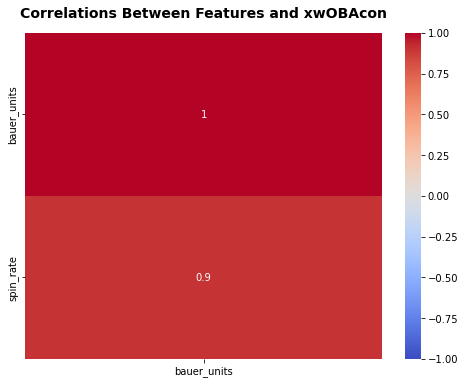

In [4]:
plt.figure(figsize = (8, 6))
sns.heatmap(data.corr()[['bauer_units']][data.corr()['bauer_units'] > .5].sort_values('bauer_units', 
                                                                                      ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.title('Correlations Between Features and xwOBAcon', fontsize = 14, fontweight = 'bold', pad = 15);

### Multicolinearity - VIF

In [5]:
features = data[['velo', 'release_extension', 'pfx_-x',
                 'pfx_z', 'release_pos_z',
                 'bauer_units', 'pitch_type', 'p_throws']]
features_vif = features.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features_vif.columns

vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
                   for i in range(len(features_vif.columns))]

vif_data.sort_values(by = 'VIF').head(10)

,feature,VIF
2,pfx_-x,1.137176
3,pfx_z,3.494445
5,bauer_units,44.227962
4,release_pos_z,101.712227
1,release_extension,154.460159
0,velo,229.677042


# Features

**Independent Variables:** Velocity, VB, HB, Release Extension, Vertical Release Position

**Dependent Variable:** Bauer Units

In [6]:
ff = features.loc[features['pitch_type'] == 'FF']
print('4-Seam shape:', ff.shape)
ff_r = features.loc[(features['pitch_type'] == 'FF') & (features['p_throws'] == 'R')]
print('RHP 4-Seam shape:', ff_r.shape)
ff_l = features.loc[(features['pitch_type'] == 'FF') & (features['p_throws'] == 'L')]
print('LHP 4-Seam shape:', ff_l.shape, '\n')
fc = features.loc[features['pitch_type'] == 'FC']
print('Cutter shape:', fc.shape)
fc_r = features.loc[(features['pitch_type'] == 'FC') & (features['p_throws'] == 'R')]
print('RHP Cutter shape:', fc_r.shape)
fc_l = features.loc[(features['pitch_type'] == 'FC') & (features['p_throws'] == 'L')]
print('LHP Cutter shape:', fc_l.shape, '\n')
si = features.loc[features['pitch_type'] == 'SI']
print('Sinker shape:', si.shape)
si_r = features.loc[(features['pitch_type'] == 'SI') & (features['p_throws'] == 'R')]
print('RHP Sinker shape:', si_r.shape)
si_l = features.loc[(features['pitch_type'] == 'SI') & (features['p_throws'] == 'L')]
print('LHP Sinker shape:', si_l.shape, '\n')
sl = features.loc[features['pitch_type'] == 'SL']
print('Slider shape:', sl.shape)
sl_r = features.loc[(features['pitch_type'] == 'SL') & (features['p_throws'] == 'R')]
print('RHP Slider shape:', sl_r.shape)
sl_l = features.loc[(features['pitch_type'] == 'SL') & (features['p_throws'] == 'L')]
print('LHP Slider shape:', sl_l.shape, '\n')
cu = features.loc[features['pitch_type'] == 'CU']
print('Curveball shape:', cu.shape)
cu_r = features.loc[(features['pitch_type'] == 'CU') & (features['p_throws'] == 'R')]
print('RHP Curveball shape:', cu_r.shape)
cu_l = features.loc[(features['pitch_type'] == 'CU') & (features['p_throws'] == 'L')]
print('LHP Curveball shape:', cu_l.shape, '\n')
ch = features.loc[features['pitch_type'] == 'CH']
print('Changeup shape:', ch.shape)
ch_r = features.loc[(features['pitch_type'] == 'CH') & (features['p_throws'] == 'R')]
print('RHP Changeup shape:', ch_r.shape)
ch_l = features.loc[(features['pitch_type'] == 'CH') & (features['p_throws'] == 'L')]
print('LHP Changeup shape:', ch_l.shape)

4-Seam shape: (40378, 8)
RHP 4-Seam shape: (28478, 8)
LHP 4-Seam shape: (11900, 8) 

Cutter shape: (8698, 8)
RHP Cutter shape: (5588, 8)
LHP Cutter shape: (3110, 8) 

Sinker shape: (21979, 8)
RHP Sinker shape: (15373, 8)
LHP Sinker shape: (6606, 8) 

Slider shape: (21518, 8)
RHP Slider shape: (16153, 8)
LHP Slider shape: (5365, 8) 

Curveball shape: (8439, 8)
RHP Curveball shape: (5743, 8)
LHP Curveball shape: (2696, 8) 

Changeup shape: (15877, 8)
RHP Changeup shape: (9626, 8)
LHP Changeup shape: (6251, 8)


# Clustering

## 4-Seam

### RHP

In [7]:
features_ff_r = ff_r.select_dtypes([np.number])
X_ff_r = features_ff_r

ss = StandardScaler()
X_ff_r_scaled = ss.fit_transform(X_ff_r)
X_ff_r_scaled[:,:] *= -1

pca_ff_r = PCA().fit_transform(X_ff_r_scaled)
model_ff_r = pd.DataFrame(data = pca_ff_r, columns = X_ff_r.columns)

km_ff_r = KMeans(n_clusters = 2, 
               random_state = 1)
km_ff_r.fit(model_ff_r)
label_ff_r = km_ff_r.fit_predict(model_ff_r)

print('Number of iterations:', km_ff_r.n_iter_)
print('Number of features:', km_ff_r.n_features_in_)
print('Number of clusters:', km_ff_r.n_clusters)
print('Inertia:', km_ff_r.inertia_, '\n')
print('Predicted clusters to points: ', label_ff_r[:10])

Number of iterations: 19
Number of features: 6
Number of clusters: 2
Inertia: 145820.41908715948 

Predicted clusters to points:  [0 0 1 1 0 0 1 0 0 0]


### LHP

In [8]:
features_ff_l = ff_l.select_dtypes([np.number])
X_ff_l = features_ff_l

ss = StandardScaler()
X_ff_l_scaled = ss.fit_transform(X_ff_l)
X_ff_l_scaled[:,:] *= -1

pca_ff_l = PCA().fit_transform(X_ff_l_scaled)
model_ff_l = pd.DataFrame(data = pca_ff_l, columns = X_ff_l.columns)

km_ff_l = KMeans(n_clusters = 2, 
               random_state = 1)
km_ff_l.fit(model_ff_l)
label_ff_l = km_ff_l.fit_predict(model_ff_l)

print('Number of iterations:', km_ff_l.n_iter_)
print('Number of features:', km_ff_l.n_features_in_)
print('Number of clusters:', km_ff_l.n_clusters)
print('Inertia:', km_ff_l.inertia_, '\n')
print('Predicted clusters to points: ', label_ff_l[:10])

Number of iterations: 20
Number of features: 6
Number of clusters: 2
Inertia: 59801.58725045042 

Predicted clusters to points:  [1 1 1 1 1 0 0 0 0 0]


### Cluster Labels - RHP 4-Seam

In [9]:
X_ff_r['label'] = label_ff_r
model_ff_r['label'] = label_ff_r

X_ff_r.groupby(by = 'label').mean().T

label,0,1
velo,94.355639,93.645034
release_extension,6.396124,6.387783
pfx_-x,9.677957,5.007259
pfx_z,13.912763,17.113293
release_pos_z,5.645358,6.092242
bauer_units,23.317350,24.875690


### Cluster Labels - LHP 4-Seam

In [10]:
X_ff_l['label'] = label_ff_l
model_ff_l['label'] = label_ff_l

X_ff_l.groupby(by = 'label').mean().T

label,0,1
velo,93.208508,92.230141
release_extension,6.379378,6.237843
pfx_-x,-9.602295,-5.777317
pfx_z,13.986826,17.108170
release_pos_z,5.748759,6.188496
bauer_units,23.197609,24.837735


## Cutter

### RHP

In [11]:
features_fc_r = fc_r.select_dtypes([np.number])
X_fc_r = features_fc_r

X_fc_r_scaled = ss.fit_transform(X_fc_r)
X_fc_r_scaled[:,:] *= -1

pca_fc_r = PCA().fit_transform(X_fc_r_scaled)
model_fc_r = pd.DataFrame(data = pca_fc_r, columns = X_fc_r.columns)

km_fc_r = KMeans(n_clusters = 2, 
               random_state = 1)

km_fc_r.fit(model_fc_r)
label_fc_r = km_fc_r.fit_predict(model_fc_r)

print('Number of iterations:', km_fc_r.n_iter_)
print('Number of features:', km_fc_r.n_features_in_)
print('Number of clusters:', km_fc_r.n_clusters)
print('Inertia:', km_fc_r.inertia_, '\n')
print("Predicted clusters to points: ", label_fc_r[:10])

Number of iterations: 10
Number of features: 6
Number of clusters: 2
Inertia: 26333.30681230446 

Predicted clusters to points:  [1 1 0 0 1 0 0 1 1 1]


### LHP

In [12]:
features_fc_l = fc_l.select_dtypes([np.number])
X_fc_l = features_fc_l

X_fc_l_scaled = ss.fit_transform(X_fc_l)
X_fc_l_scaled[:,:] *= -1

pca_fc_l = PCA().fit_transform(X_fc_l_scaled)
model_fc_l = pd.DataFrame(data = pca_fc_l, columns = X_fc_l.columns)

km_fc_l = KMeans(n_clusters = 2, 
               random_state = 1)

km_fc_l.fit(model_fc_l)
label_fc_l = km_fc_r.fit_predict(model_fc_l)

print('Number of iterations:', km_fc_l.n_iter_)
print('Number of features:', km_fc_l.n_features_in_)
print('Number of clusters:', km_fc_l.n_clusters)
print('Inertia:', km_fc_l.inertia_, '\n')
print("Predicted clusters to points: ", label_fc_l[:10])

Number of iterations: 11
Number of features: 6
Number of clusters: 2
Inertia: 14615.74407853432 

Predicted clusters to points:  [0 0 0 0 1 1 0 1 1 1]


### Cluster Labels - RHP Cutter

In [13]:
X_fc_r['label'] = label_fc_r
model_fc_r['label'] = label_fc_r

X_fc_r.groupby(by = 'label').mean().T

label,0,1
velo,87.757264,91.074128
release_extension,6.172285,6.410392
pfx_-x,-4.602821,-1.055015
pfx_z,5.207433,10.457267
release_pos_z,6.018762,5.894520
bauer_units,28.220683,25.693489


### Cluster Labels - LHP Cutter

In [14]:
X_fc_l['label'] = label_fc_l
model_fc_l['label'] = label_fc_l

X_fc_l.groupby(by = 'label').mean().T

label,0,1
velo,85.645479,88.321006
release_extension,6.154736,6.245687
pfx_-x,3.434467,-1.043482
pfx_z,6.517266,10.047220
release_pos_z,5.822384,5.792093
bauer_units,27.266273,24.485447


## Sinker

### RHP

In [15]:
features_si_r = si_r.select_dtypes([np.number])
X_si_r = features_si_r

X_si_r_scaled = ss.fit_transform(X_si_r)
X_si_r_scaled[:,:] *= -1

pca_si_r = PCA().fit_transform(X_si_r_scaled)
model_si_r = pd.DataFrame(data = pca_si_r, columns = X_si_r.columns)

km_si_r = KMeans(n_clusters = 2, 
                 random_state = 1)

km_si_r.fit(model_si_r)
label_si_r = km_si_r.fit_predict(model_si_r)

print('Number of iterations:', km_si_r.n_iter_)
print('Number of features:', km_si_r.n_features_in_)
print('Number of clusters:', km_si_r.n_clusters)
print('Inertia:', km_si_r.inertia_, '\n')
print("Predicted clusters to points: ", label_si_r[:10])

Number of iterations: 23
Number of features: 6
Number of clusters: 2
Inertia: 77976.70915096304 

Predicted clusters to points:  [1 1 0 1 0 1 0 0 0 0]


### LHP

In [16]:
features_si_l = si_l.select_dtypes([np.number])
X_si_l = features_si_l

X_si_l_scaled = ss.fit_transform(X_si_l)
X_si_l_scaled[:,:] *= -1

pca_si_l = PCA().fit_transform(X_si_l_scaled)
model_si_l = pd.DataFrame(data = pca_si_l, columns = X_si_l.columns)

km_si_l = KMeans(n_clusters = 2, 
                 random_state = 1)

km_si_l.fit(model_si_l)
label_si_l = km_si_l.fit_predict(model_si_l)

print('Number of iterations:', km_si_l.n_iter_)
print('Number of features:', km_si_l.n_features_in_)
print('Number of clusters:', km_si_l.n_clusters)
print('Inertia:', km_si_l.inertia_, '\n')
print("Predicted clusters to points: ", label_si_l[:10])

Number of iterations: 15
Number of features: 6
Number of clusters: 2
Inertia: 32278.091684313284 

Predicted clusters to points:  [0 0 0 0 1 0 0 0 0 0]


### Cluster Labels - RHP Sinker

In [17]:
X_si_r['label'] = label_si_r
model_si_r['label'] = label_si_r

X_si_r.groupby(by = 'label').mean().T

label,0,1
velo,92.535361,93.891810
release_extension,6.165859,6.390915
pfx_-x,16.272975,13.802595
pfx_z,5.085281,11.309728
release_pos_z,5.368407,5.919437
bauer_units,22.469583,23.144973


### Cluster Labels - LHP Sinker

In [18]:
X_si_l['label'] = label_si_l
model_si_l['label'] = label_si_l

X_si_l.groupby(by = 'label').mean().T

label,0,1
velo,92.528097,91.436324
release_extension,6.462507,6.070050
pfx_-x,-13.687718,-16.232636
pfx_z,11.939431,5.798837
release_pos_z,6.000842,5.568666
bauer_units,22.940993,22.072996


## Slider

### RHP

In [19]:
features_sl_r = sl_r.select_dtypes([np.number])
X_sl_r = features_sl_r

X_sl_r_scaled = ss.fit_transform(X_sl_r)
X_sl_r_scaled[:,:] *= -1

pca_sl_r = PCA().fit_transform(X_sl_r_scaled)
model_sl_r = pd.DataFrame(data = pca_sl_r, columns = X_sl_r.columns)

km_sl_r = KMeans(n_clusters = 2, random_state = 1)

km_sl_r.fit(model_sl_r)
label_sl_r = km_sl_r.fit_predict(model_sl_r)

print('Number of iterations:', km_sl_r.n_iter_)
print('Number of features:', km_sl_r.n_features_in_)
print('Number of clusters:', km_sl_r.n_clusters)
print('Inertia:', km_sl_r.inertia_, '\n')
print("Predicted clusters to points: ", label_sl_r[:10])

Number of iterations: 17
Number of features: 6
Number of clusters: 2
Inertia: 73838.8661743909 

Predicted clusters to points:  [1 1 1 0 1 1 0 1 1 1]


### LHP

In [20]:
features_sl_l = sl_l.select_dtypes([np.number])
X_sl_l = features_sl_l

X_sl_l_scaled = ss.fit_transform(X_sl_l)
X_sl_l_scaled[:,:] *= -1

pca_sl_l = PCA().fit_transform(X_sl_l_scaled)
model_sl_l = pd.DataFrame(data = pca_sl_l, columns = X_sl_l.columns)

km_sl_l = KMeans(n_clusters = 2, random_state = 1)

km_sl_l.fit(model_sl_l)
label_sl_l = km_sl_l.fit_predict(model_sl_l)

print('Number of iterations:', km_sl_l.n_iter_)
print('Number of features:', km_sl_l.n_features_in_)
print('Number of clusters:', km_sl_l.n_clusters)
print('Inertia:', km_sl_l.inertia_, '\n')
print("Predicted clusters to points: ", label_sl_l[:10])

Number of iterations: 12
Number of features: 6
Number of clusters: 2
Inertia: 24021.114783493773 

Predicted clusters to points:  [1 1 1 1 1 1 1 0 0 0]


### Cluster Labels - RHP Slider

In [21]:
X_sl_r['label'] = label_sl_r
model_sl_r['label'] = label_sl_r

X_sl_r.groupby(by = 'label').mean().T

label,0,1
velo,81.841597,86.288757
release_extension,6.298685,6.231142
pfx_-x,-11.591936,-3.462272
pfx_z,0.202180,2.600385
release_pos_z,5.437729,5.943962
bauer_units,31.521431,27.220852


### Cluster Labels - LHP Slider

In [22]:
X_sl_l['label'] = label_sl_l
model_sl_l['label'] = label_sl_l

X_sl_l.groupby(by = 'label').mean().T

label,0,1
velo,85.521642,81.791336
release_extension,6.326404,6.113405
pfx_-x,3.076059,8.552534
pfx_z,3.601419,-1.293776
release_pos_z,5.998857,5.729121
bauer_units,26.329066,30.126864


## Curveball

### RHP

In [23]:
features_cu_r = cu_r.select_dtypes([np.number])
X_cu_r = features_cu_r

X_cu_r_scaled = ss.fit_transform(X_cu_r)
X_cu_r_scaled[:,:] *= -1

pca_cu_r = PCA().fit_transform(X_cu_r_scaled)
model_cu_r = pd.DataFrame(data = pca_cu_r, columns = X_cu_r.columns)

km_cu_r = KMeans(n_clusters = 2, random_state = 1)

km_cu_r.fit(model_cu_r)
label_cu_r = km_cu_r.fit_predict(model_cu_r)

print('Number of iterations:', km_cu_r.n_iter_)
print('Number of features:', km_cu_r.n_features_in_)
print('Number of clusters:', km_cu_r.n_clusters)
print('Inertia:', km_cu_r.inertia_, '\n')
print("Predicted clusters to points: ", label_cu_r[:10])

Number of iterations: 9
Number of features: 6
Number of clusters: 2
Inertia: 27443.705789738637 

Predicted clusters to points:  [1 0 0 1 0 1 0 0 0 0]


### LHP

In [24]:
features_cu_l = cu_l.select_dtypes([np.number])
X_cu_l = features_cu_l

X_cu_l_scaled = ss.fit_transform(X_cu_l)
X_cu_l_scaled[:,:] *= -1

pca_cu_l = PCA().fit_transform(X_cu_l_scaled)
model_cu_l = pd.DataFrame(data = pca_cu_l, columns = X_cu_l.columns)

km_cu_l = KMeans(n_clusters = 2, random_state = 1)

km_cu_l.fit(model_cu_l)
label_cu_l = km_cu_l.fit_predict(model_cu_l)

print('Number of iterations:', km_cu_l.n_iter_)
print('Number of features:', km_cu_l.n_features_in_)
print('Number of clusters:', km_cu_l.n_clusters)
print('Inertia:', km_cu_l.inertia_, '\n')
print("Predicted clusters to points: ", label_cu_l[:10])

Number of iterations: 18
Number of features: 6
Number of clusters: 2
Inertia: 12341.086215473744 

Predicted clusters to points:  [0 1 1 1 1 1 0 1 1 1]


### Cluster Labels - RHP Curveball

In [25]:
X_cu_r['label'] = label_cu_r
model_cu_r['label'] = label_cu_r

X_cu_r.groupby(by = 'label').mean().T

label,0,1
velo,77.132215,80.687455
release_extension,6.170805,6.290199
pfx_-x,-12.211544,-7.536870
pfx_z,-12.516779,-6.565305
release_pos_z,6.039284,5.910575
bauer_units,35.276243,29.366533


### Cluster Labels - LHP Curveball

In [26]:
X_cu_l['label'] = label_cu_l
model_cu_l['label'] = label_cu_l

X_cu_l.groupby(by = 'label').mean().T

label,0,1
velo,79.806130,75.902960
release_extension,6.145359,6.083012
pfx_-x,3.953905,11.754517
pfx_z,-4.230053,-9.394595
release_pos_z,6.156497,5.854755
bauer_units,27.909984,33.826973


## Changeup

### RHP

In [27]:
features_ch_r = ch_r.select_dtypes([np.number])
X_ch_r = features_ch_r

X_ch_r_scaled = ss.fit_transform(X_ch_r)
X_ch_r_scaled[:,:] *= -1

pca_ch_r = PCA().fit_transform(X_ch_r)
model_ch_r = pd.DataFrame(data = pca_ch_r, columns = X_ch_r.columns)

km_ch_r = KMeans(n_clusters = 2, random_state = 1)

km_ch_r.fit(model_ch_r)
label_ch_r = km_ch_r.fit_predict(model_ch_r)

print('Number of iterations:', km_ch_r.n_iter_)
print('Number of features:', km_ch_r.n_features_in_)
print('Number of clusters:', km_ch_r.n_clusters)
print('Inertia:', km_ch_r.inertia_, '\n')
print("Predicted clusters to points: ", label_ch_r[:10])

Number of iterations: 8
Number of features: 6
Number of clusters: 2
Inertia: 444420.8713612234 

Predicted clusters to points:  [1 1 1 1 1 0 0 0 0 1]


### LHP

In [28]:
features_ch_l = ch_l.select_dtypes([np.number])
X_ch_l = features_ch_l

X_ch_l_scaled = ss.fit_transform(X_ch_l)
X_ch_l_scaled[:,:] *= -1

pca_ch_l = PCA().fit_transform(X_ch_l)
model_ch_l = pd.DataFrame(data = pca_ch_l, columns = X_ch_l.columns)

km_ch_l = KMeans(n_clusters = 2, random_state = 1)

km_ch_l.fit(model_ch_l)
label_ch_l = km_ch_l.fit_predict(model_ch_l)

print('Number of iterations:', km_ch_l.n_iter_)
print('Number of features:', km_ch_l.n_features_in_)
print('Number of clusters:', km_ch_l.n_clusters)
print('Inertia:', km_ch_l.inertia_, '\n')
print("Predicted clusters to points: ", label_ch_l[:10])

Number of iterations: 11
Number of features: 6
Number of clusters: 2
Inertia: 243836.4998981913 

Predicted clusters to points:  [1 1 1 1 0 1 0 1 0 1]


### Cluster Labels - RHP Changeup

In [29]:
X_ch_r['label'] = label_ch_r
model_ch_r['label'] = label_ch_r

X_ch_r.groupby(by = 'label').mean().T

label,0,1
velo,85.009131,85.921629
release_extension,6.359489,6.280906
pfx_-x,13.359396,14.045385
pfx_z,9.975949,2.262176
release_pos_z,5.944283,5.600772
bauer_units,20.695042,20.243995


### Cluster Labels - LHP Changeup

In [30]:
X_ch_l['label'] = label_ch_l
model_ch_l['label'] = label_ch_l

X_ch_l.groupby(by = 'label').mean().T

label,0,1
velo,83.345536,83.600167
release_extension,6.250488,6.222566
pfx_-x,-12.913323,-14.564151
pfx_z,11.814419,4.675582
release_pos_z,6.002524,5.709978
bauer_units,21.871493,20.164678


# Linear Regression Modeling

## Linear Regression - 4-Seam

### RHP

In [31]:
X = X_ff_r.drop(columns = ['bauer_units'])
X = sm.add_constant(X)
y = X_ff_r['bauer_units']

ols_ff_r = sm.OLS(y, X).fit()
pred_ff_r = ols_ff_r.predict(X)
fitted_vals_ff_r = ols_ff_r.fittedvalues
residuals_ff_r = ols_ff_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_ff_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ff_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ff_r), 4))
print(ols_ff_r.summary())

MSE: 2.5145
RMSE: 1.5857
MAE: 1.231
                            OLS Regression Results                            
Dep. Variable:            bauer_units   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     1879.
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:07:58   Log-Likelihood:                -53538.
No. Observations:               28478   AIC:                         1.071e+05
Df Residuals:                   28471   BIC:                         1.071e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
co

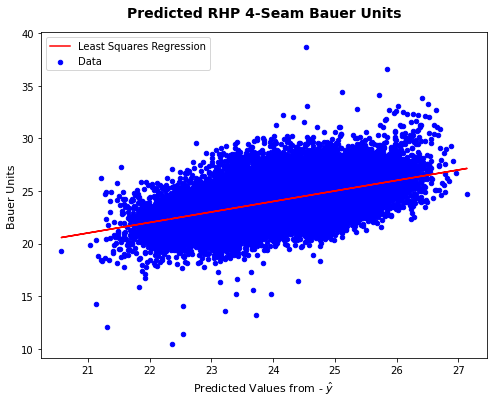

In [32]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_ff_r, y, s = 20, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ff_r, np.poly1d(np.polyfit(pred_ff_r, y, 1))(pred_ff_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Bauer Units', fontsize = 11)
plt.title('Predicted RHP 4-Seam Bauer Units', fontsize = 14, fontweight = 'bold', pad = 15);

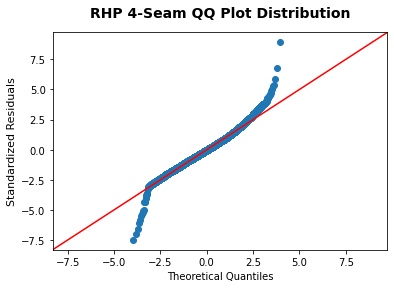

In [33]:
sm.qqplot(residuals_ff_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP 4-Seam QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [34]:
X = X_ff_l.drop(columns = ['bauer_units'])
X = sm.add_constant(X)
y = X_ff_l['bauer_units']

ols_ff_l = sm.OLS(y, X).fit()
pred_ff_l = ols_ff_l.predict(X)
fitted_vals_ff_l = ols_ff_l.fittedvalues
residuals_ff_l = ols_ff_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_ff_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ff_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ff_l), 4))
print(ols_ff_l.summary())

MSE: 2.7159
RMSE: 1.648
MAE: 1.2858
                            OLS Regression Results                            
Dep. Variable:            bauer_units   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     684.5
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:07:59   Log-Likelihood:                -22830.
No. Observations:               11900   AIC:                         4.567e+04
Df Residuals:                   11893   BIC:                         4.573e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
co

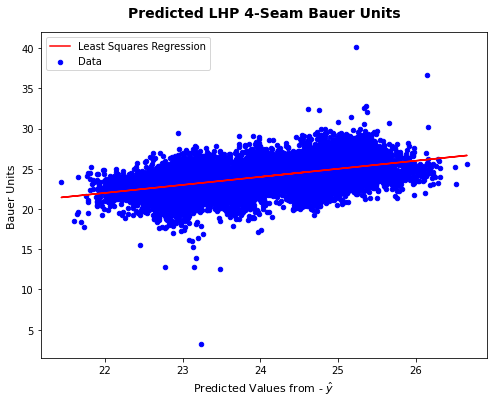

In [35]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_ff_l, y, s = 20, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ff_l, np.poly1d(np.polyfit(pred_ff_l, y, 1))(pred_ff_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Bauer Units', fontsize = 11)
plt.title('Predicted LHP 4-Seam Bauer Units', fontsize = 14, fontweight = 'bold', pad = 15);

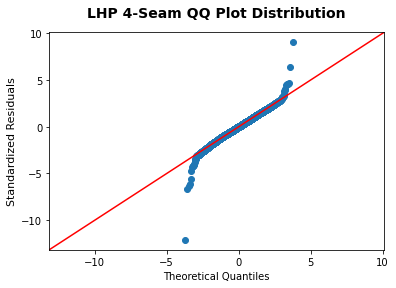

In [36]:
sm.qqplot(residuals_ff_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP 4-Seam QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Cutter

### RHP

In [37]:
X = X_fc_r.drop(columns = ['bauer_units'])
X = sm.add_constant(X)
y = X_fc_r['bauer_units']

ols_fc_r = sm.OLS(y, X).fit()
pred_fc_r = ols_fc_r.predict(X)
fitted_vals_fc_r = ols_fc_r.fittedvalues
residuals_fc_r = ols_fc_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_fc_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_fc_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_fc_r), 4))
print(ols_fc_r.summary())

MSE: 4.528
RMSE: 2.1279
MAE: 1.6613
                            OLS Regression Results                            
Dep. Variable:            bauer_units   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     424.7
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:07:59   Log-Likelihood:                -12149.
No. Observations:                5588   AIC:                         2.431e+04
Df Residuals:                    5581   BIC:                         2.436e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
co

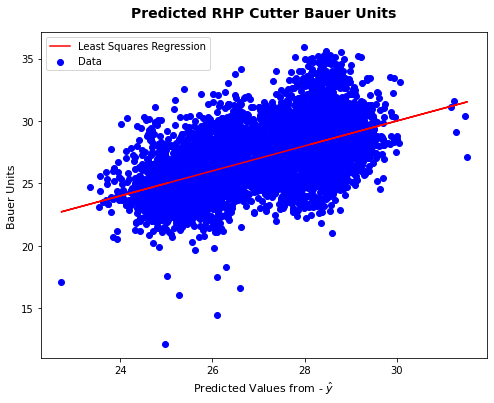

In [38]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_fc_r, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fc_r, np.poly1d(np.polyfit(pred_fc_r, y, 1))(pred_fc_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Bauer Units', fontsize = 11)
plt.title('Predicted RHP Cutter Bauer Units', fontsize = 14, fontweight = 'bold', pad = 15);

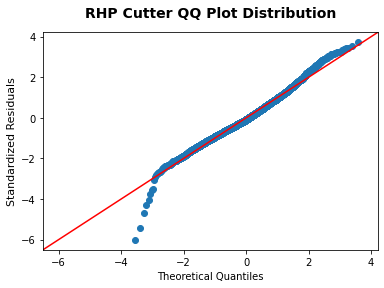

In [39]:
sm.qqplot(residuals_fc_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Cutter QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [40]:
X = X_fc_l.drop(columns = ['bauer_units'])
X = sm.add_constant(X)
y = X_fc_l['bauer_units']

ols_fc_l = sm.OLS(y, X).fit()
pred_fc_l = ols_fc_l.predict(X)
fitted_vals_fc_l = ols_fc_l.fittedvalues
residuals_fc_l = ols_fc_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_fc_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_fc_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_fc_l), 4))
print(ols_fc_l.summary())

MSE: 3.6915
RMSE: 1.9213
MAE: 1.4735
                            OLS Regression Results                            
Dep. Variable:            bauer_units   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     300.9
Date:                Thu, 03 Mar 2022   Prob (F-statistic):          1.74e-304
Time:                        15:07:59   Log-Likelihood:                -6443.8
No. Observations:                3110   AIC:                         1.290e+04
Df Residuals:                    3103   BIC:                         1.294e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

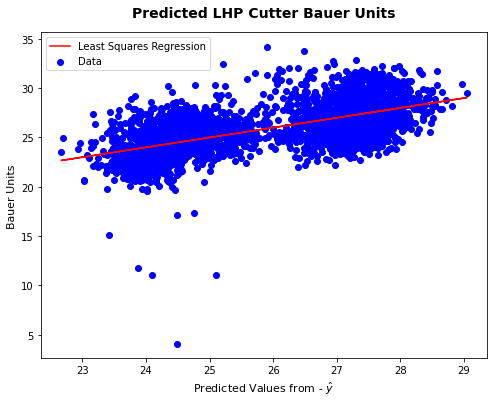

In [41]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_fc_l, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fc_l, np.poly1d(np.polyfit(pred_fc_l, y, 1))(pred_fc_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Bauer Units', fontsize = 11)
plt.title('Predicted LHP Cutter Bauer Units', fontsize = 14, fontweight = 'bold', pad = 15);

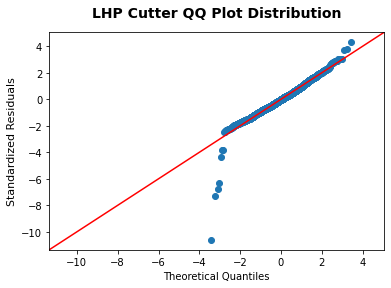

In [42]:
sm.qqplot(residuals_fc_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Cutter QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Sinker

### RHP

In [43]:
X = X_si_r.drop(columns = ['bauer_units'])
X = sm.add_constant(X)
y = X_si_r['bauer_units']

ols_si_r = sm.OLS(y, X).fit()
pred_si_r = ols_si_r.predict(X)
fitted_vals_si_r = ols_si_r.fittedvalues
residuals_si_r = ols_si_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_si_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_si_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_si_r), 4))
print(ols_si_r.summary())

MSE: 3.0637
RMSE: 1.7503
MAE: 1.3504
                            OLS Regression Results                            
Dep. Variable:            bauer_units   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     262.0
Date:                Thu, 03 Mar 2022   Prob (F-statistic):          2.29e-320
Time:                        15:08:00   Log-Likelihood:                -30419.
No. Observations:               15373   AIC:                         6.085e+04
Df Residuals:                   15366   BIC:                         6.091e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

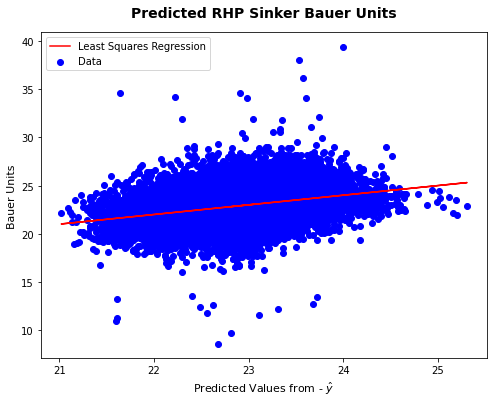

In [44]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_si_r, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_si_r, np.poly1d(np.polyfit(pred_si_r, y, 1))(pred_si_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Bauer Units', fontsize = 11)
plt.title('Predicted RHP Sinker Bauer Units', fontsize = 14, fontweight = 'bold', pad = 15);

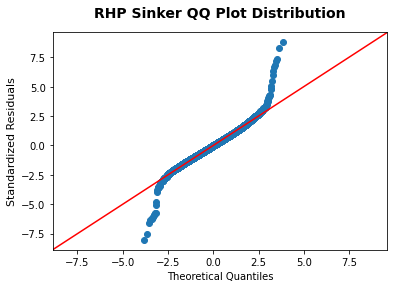

In [45]:
sm.qqplot(residuals_si_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Sinker QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [46]:
X = X_si_l.drop(columns = ['bauer_units'])
X = sm.add_constant(X)
y = X_si_l['bauer_units']

ols_si_l = sm.OLS(y, X).fit()
pred_si_l = ols_si_l.predict(X)
fitted_vals_si_l = ols_si_l.fittedvalues
residuals_si_l = ols_si_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_si_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_si_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_si_l), 4))
print(ols_si_l.summary())

MSE: 3.1642
RMSE: 1.7788
MAE: 1.3753
                            OLS Regression Results                            
Dep. Variable:            bauer_units   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     172.2
Date:                Thu, 03 Mar 2022   Prob (F-statistic):          3.99e-204
Time:                        15:08:00   Log-Likelihood:                -13178.
No. Observations:                6606   AIC:                         2.637e+04
Df Residuals:                    6599   BIC:                         2.642e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

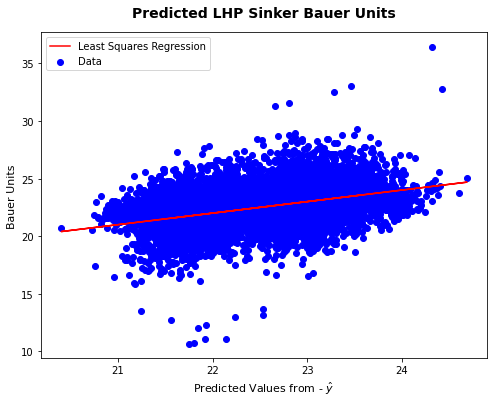

In [47]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_si_l, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_si_l, np.poly1d(np.polyfit(pred_si_l, y, 1))(pred_si_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Bauer Units', fontsize = 11)
plt.title('Predicted LHP Sinker Bauer Units', fontsize = 14, fontweight = 'bold', pad = 15);

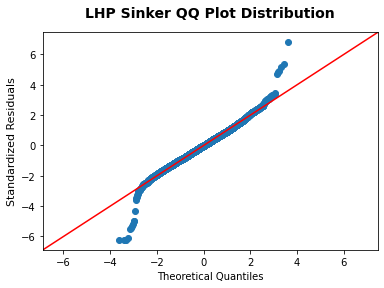

In [48]:
sm.qqplot(residuals_si_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Sinker QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Slider

### RHP

In [49]:
X = X_sl_r.drop(columns = ['bauer_units'])
X = sm.add_constant(X)
y = X_sl_r['bauer_units']

ols_sl_r = sm.OLS(y, X).fit()
pred_sl_r = ols_sl_r.predict(X)
fitted_vals_sl_r = ols_sl_r.fittedvalues
residuals_sl_r = ols_sl_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_sl_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_sl_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_sl_r), 4))
print(ols_sl_r.summary())

MSE: 6.3307
RMSE: 2.5161
MAE: 1.9347
                            OLS Regression Results                            
Dep. Variable:            bauer_units   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     2011.
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:08:00   Log-Likelihood:                -37825.
No. Observations:               16153   AIC:                         7.566e+04
Df Residuals:                   16146   BIC:                         7.572e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

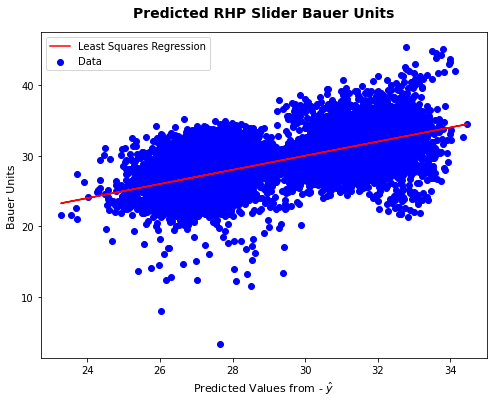

In [50]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_sl_r, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_sl_r, np.poly1d(np.polyfit(pred_sl_r, y, 1))(pred_sl_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Bauer Units', fontsize = 11)
plt.title('Predicted RHP Slider Bauer Units', fontsize = 14, fontweight = 'bold', pad = 15);

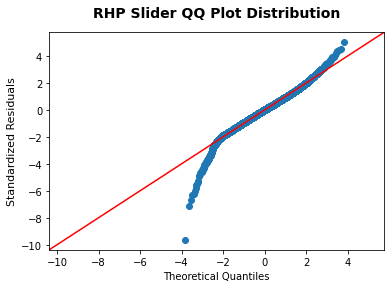

In [51]:
sm.qqplot(residuals_sl_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Slider QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [52]:
X = X_sl_l.drop(columns = ['bauer_units'])
X = sm.add_constant(X)
y = X_sl_l['bauer_units']

ols_sl_l = sm.OLS(y, X).fit()
pred_sl_l = ols_sl_l.predict(X)
fitted_vals_sl_l = ols_sl_l.fittedvalues
residuals_sl_l = ols_sl_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_sl_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_sl_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_sl_l), 4))
print(ols_sl_l.summary())

MSE: 5.479
RMSE: 2.3407
MAE: 1.7959
                            OLS Regression Results                            
Dep. Variable:            bauer_units   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     674.4
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:08:01   Log-Likelihood:                -12175.
No. Observations:                5365   AIC:                         2.436e+04
Df Residuals:                    5358   BIC:                         2.441e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
co

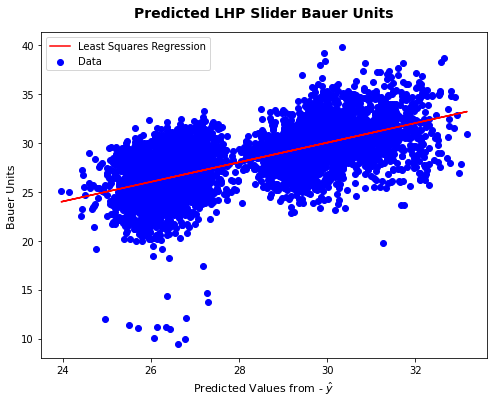

In [53]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_sl_l, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_sl_l, np.poly1d(np.polyfit(pred_sl_l, y, 1))(pred_sl_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Bauer Units', fontsize = 11)
plt.title('Predicted LHP Slider Bauer Units', fontsize = 14, fontweight = 'bold', pad = 15);

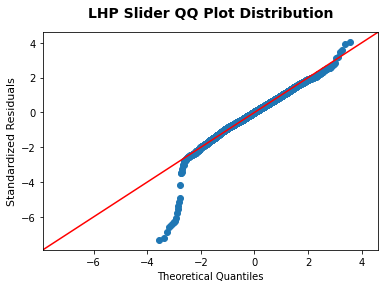

In [54]:
sm.qqplot(residuals_sl_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Slider QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Curveball

### RHP

In [55]:
X = X_cu_r.drop(columns = ['bauer_units'])
X = sm.add_constant(X)
y = X_cu_r['bauer_units']

ols_cu_r = sm.OLS(y, X).fit()
pred_cu_r = ols_cu_r.predict(X)
fitted_vals_cu_r = ols_cu_r.fittedvalues
residuals_cu_r = ols_cu_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_cu_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_cu_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_cu_r), 4))
print(ols_cu_r.summary())

MSE: 8.6908
RMSE: 2.948
MAE: 2.3438
                            OLS Regression Results                            
Dep. Variable:            bauer_units   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     1127.
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:08:01   Log-Likelihood:                -14358.
No. Observations:                5743   AIC:                         2.873e+04
Df Residuals:                    5736   BIC:                         2.878e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
co

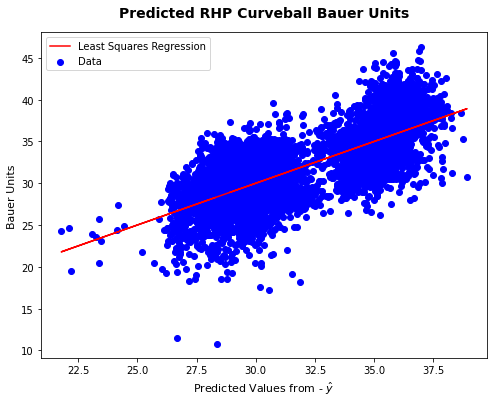

In [56]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_cu_r, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_cu_r, np.poly1d(np.polyfit(pred_cu_r, y, 1))(pred_cu_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Bauer Units', fontsize = 11)
plt.title('Predicted RHP Curveball Bauer Units', fontsize = 14, fontweight = 'bold', pad = 15);

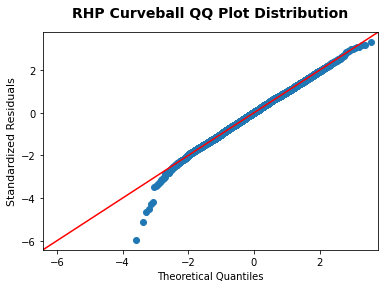

In [57]:
sm.qqplot(residuals_cu_r, line='45', fit=True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Curveball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [58]:
X = X_cu_l.drop(columns = ['bauer_units'])
X = sm.add_constant(X)
y = X_cu_l['bauer_units']

ols_cu_l = sm.OLS(y, X).fit()
pred_cu_l = ols_cu_l.predict(X)
fitted_vals_cu_l = ols_cu_l.fittedvalues
residuals_cu_l = ols_cu_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_cu_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_cu_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_cu_l), 4))
print(ols_cu_l.summary())

MSE: 6.2619
RMSE: 2.5024
MAE: 1.9071
                            OLS Regression Results                            
Dep. Variable:            bauer_units   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     758.3
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:08:01   Log-Likelihood:                -6298.4
No. Observations:                2696   AIC:                         1.261e+04
Df Residuals:                    2689   BIC:                         1.265e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

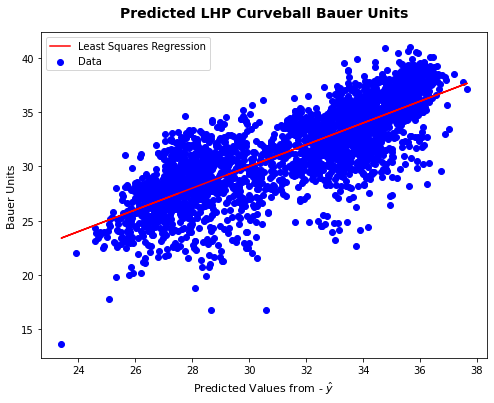

In [59]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_cu_l, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_cu_l, np.poly1d(np.polyfit(pred_cu_l, y, 1))(pred_cu_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Bauer Units', fontsize = 11)
plt.title('Predicted LHP Curveball Bauer Units', fontsize = 14, fontweight = 'bold', pad = 15);

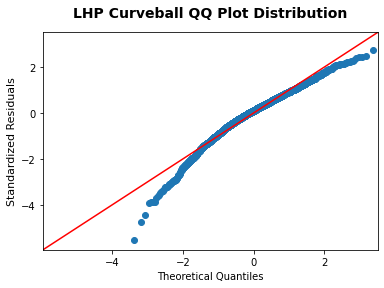

In [60]:
sm.qqplot(residuals_cu_l, line='45', fit=True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Curveball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Changeup

### RHP

In [61]:
X = X_ch_r.drop(columns = ['bauer_units'])
X = sm.add_constant(X)
y = X_ch_r['bauer_units']

ols_ch_r = sm.OLS(y, X).fit()
pred_ch_r = ols_ch_r.predict(X)
fitted_vals_ch_r = ols_ch_r.fittedvalues
residuals_ch_r = ols_ch_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_ch_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ch_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ch_r), 4))
print(ols_ch_r.summary())

MSE: 9.8025
RMSE: 3.1309
MAE: 2.3658
                            OLS Regression Results                            
Dep. Variable:            bauer_units   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     362.8
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:08:02   Log-Likelihood:                -24645.
No. Observations:                9626   AIC:                         4.930e+04
Df Residuals:                    9619   BIC:                         4.935e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

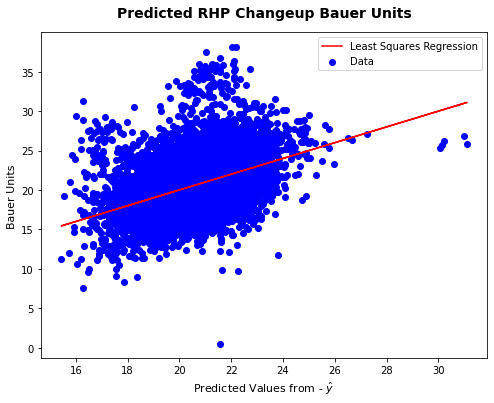

In [62]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_ch_r, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ch_r, np.poly1d(np.polyfit(pred_ch_r, y, 1))(pred_ch_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Bauer Units', fontsize = 11)
plt.title('Predicted RHP Changeup Bauer Units', fontsize = 14, fontweight = 'bold', pad = 15);

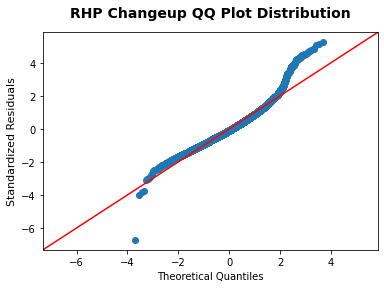

In [63]:
sm.qqplot(residuals_ch_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Changeup QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [64]:
X = X_ch_l.drop(columns = ['bauer_units'])
X = sm.add_constant(X)
y = X_ch_l['bauer_units']

ols_ch_l = sm.OLS(y, X).fit()
pred_ch_l = ols_ch_l.predict(X)
fitted_vals_ch_l = ols_ch_l.fittedvalues
residuals_ch_l = ols_ch_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_ch_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ch_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ch_l), 4))
print(ols_ch_l.summary())

MSE: 7.9036
RMSE: 2.8113
MAE: 2.2225
                            OLS Regression Results                            
Dep. Variable:            bauer_units   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     604.9
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:08:02   Log-Likelihood:                -15331.
No. Observations:                6251   AIC:                         3.068e+04
Df Residuals:                    6244   BIC:                         3.072e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

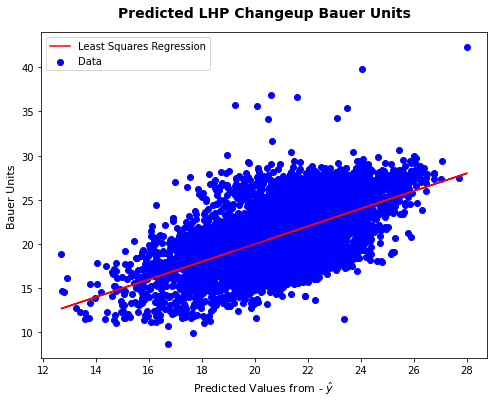

In [65]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_ch_l, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ch_l, np.poly1d(np.polyfit(pred_ch_l, y, 1))(pred_ch_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Bauer Units', fontsize = 11)
plt.title('Predicted LHP Changeup Bauer Units', fontsize = 14, fontweight = 'bold', pad = 15);

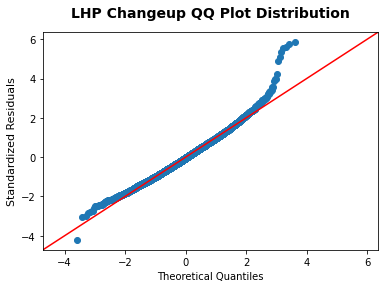

In [66]:
sm.qqplot(residuals_ch_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Changeup QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);